# Benchmark MonteCarlo

This notebook benchmarks a analytical Gaussian uncertainty propagation against a MonteCarlo simulation. Uncertain observations are propagated into an experimental variogram. The aim is to provide evidence that MonteCarlo simulations at suffieciently large iterations can substitute a Gaussian uncertainty propagations in terms of error margins. MonteCarlo simulations are a preferred framework in this case as they are easily adaptable to the numerical geostatistics packages SciKit-GStat and GSTools, which do not implement symbolic functions for deriving analytical solutions.

## 1. Analytical solution

As a first step the analytical solution for the Matheron estimator is presented. This is the most commonly used estimator, which is also pretty straightforward mathematically.

In [1]:
import abc
import random
import skgstat as skg
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sympy import Integer, Symbol, IndexedBase
from sympy import diff, summation, sqrt, Abs

plt.style.use('./paper.mplstyle')

In [2]:
class ExactModel(abc.ABC):
    i = Symbol('i', integer=True)
    N = Symbol('N', integer=True)
    x = IndexedBase('x', integer=True)

    def __init__(self, data=None):
        if data is not None:
            self.init_data(data)
        
    def init_data(self, data):
        self.data = data
        self.model = self.model().subs(self.N, len(data) - 1)
        self.diff = diff(self.model, self.x[self.i])
    
    def __call__(self, data=None, evalf=False):
        if data is not None:
            self.init_data(data)
        
        # go
        res =  self.model.doit().subs([(self.x[i], self.data[i]) for i in range(len(self.data))])
        if evalf:
            return res.evalf()
        else:
            return res
        
    @property
    def model(self):
        return self.model
    
    @property
    def deriv(self):
        return self.diff
    
    def solve_diff(self, evalf=False):
        res = self.diff.doit().subs([(self.x[i], self.data[i]) for i in range(len(self.data))])
        if evalf:
            return res.evalf()
        else:
            return res
        
    @abc.abstractclassmethod
    def model(cls):
        pass
    
    @classmethod
    def derivative(cls):
        return diff(cls.model(), cls.x[cls.i])
    

In [3]:
class Matheron(ExactModel):
    @classmethod
    def model(cls):
        return Integer(1) / (2 * cls.N) * summation(cls.x[cls.i]**2, (cls.i, 0, cls.N))
#        return Integer(1) / (2 * cls.N) * summation((cls.x[cls.i] - cls.x[cls.i - 1])**2, (cls.i, 1, cls.N))
    

class Cressie(ExactModel):
    @classmethod
    def model(cls):
        nominator = ((1 / cls.N) * summation(sqrt(Abs(cls.x[cls.i])), (cls.i, 0, cls.N)))**4
        denominator = (Integer(457) / Integer(1000)) + (Integer(494) / Integer(1000)) / cls.N + (Integer(45) / Integer(1000)) / cls.N**2
        return (Integer(1) / Integer(2)) * (nominator / denominator)

In [4]:
Matheron.model()

Sum(x[i]**2, (i, 0, N))/(2*N)

In [5]:
Matheron.derivative()

Sum(2*x[i], (i, 0, N))/(2*N)

In [6]:
Cressie.model()

Sum(sqrt(Abs(x[i])), (i, 0, N))**4/(2*N**4*(457/1000 + 247/(500*N) + 9/(200*N**2)))

In [7]:
Cressie.derivative()

2*Sum(sign(x[i])/(2*sqrt(Abs(x[i]))), (i, 0, N))*Sum(sqrt(Abs(x[i])), (i, 0, N))**3/(N**4*(457/1000 + 247/(500*N) + 9/(200*N**2)))

/home/mirko/Dropbox/python/scikit-gstat/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


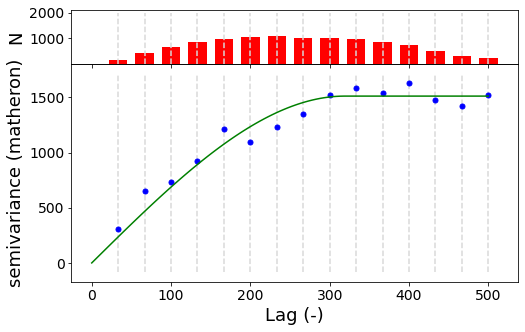

In [8]:
# Load data with a seed
coords, values = skg.data.pancake(N=150, seed=42).get('sample')

vario = skg.Variogram(coords, values, n_lags=15)
vario.maxlag = 500
fig = vario.plot()

In [67]:
# a uint8 based PNG has a inherit error of 1
dx = Integer(1) / Integer(2)

lags = []
errors = []

# create the bin edges
groups = list(zip(vario.bins, vario.bins[1:]))

for data in tqdm(vario.lag_classes(), total=vario.n_lags):
    # create the exact solution
    m = Matheron(data)
    err = m.solve_diff() * dx
    
    # append
    lags.append(m)
    errors.append(err)
print([e.evalf() for e in errors])

100%|██████████| 15/15 [17:08<00:00, 68.58s/it] 

[8.21779141104295, 12.8846153846154, 14.2357784431138, 15.7694954128440, 19.0000000000000, 18.4990680335508, 19.2524797114518, 20.1920432220040, 21.4853228962816, 22.3324742268043, 22.0737514518003, 22.9039509536784, 21.4457364341085, 21.3625377643505, 22.1875000000000]


In [68]:
# save these results as well
gaus_errors = np.array([e.evalf() for e in errors])
np.save('./data/gauss_uncertainty.npy', gaus_errors)

## 1.2 MonteCarlo Simulation

In [9]:
N = 50000
RERUN = False

# calculate the distance matrix only once
ms = skg.MetricSpace(coords)

# prepare input data
input_data = np.array([values,] * N)

# in the special case of uint8 values we just turn the values into floats of
# within the range of one R-band value
# i.e.: v = 127 -> [127.0:128.0[
np.random.seed(42)
input_data = input_data.astype(float) + np.random.random(size=input_data.shape) - 0.5

if RERUN:
    results = np.zeros((vario.n_lags, N))

    for i, vals in tqdm(enumerate(input_data), total=N):
        v = skg.Variogram(ms, vals, n_lags=vario.n_lags, maxlag=500)
        results[:,i] = v.experimental
    
    # save the data
    np.save('./data/observation_uncertainty.npy', results)
else:
    results = np.load('./data/observation_uncertainty.npy')

print((np.max(results, axis=1) - np.min(results, axis=1)).round(1))

[ 9.3 10.9 10.6 13.  15.8 13.2 15.5 16.1 17.9 19.6 19.5 20.5 21.4 22.7
 28.9]


In [10]:
results.shape

(15, 50000)

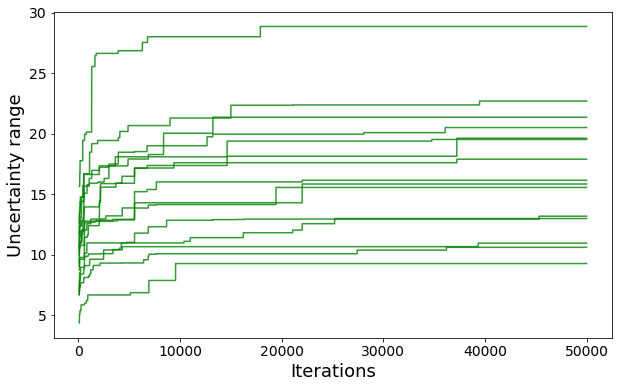

In [18]:
sizes = (100, 500, 1000, 2000, 5000, 10000, 15000, 20000, 30000, 40000, 50000)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for lag in range(vario.n_lags):
        y = [np.max(results[lag, :size]) - np.min(results[lag, :size]) for size in range(100, N)]
#        y = [np.percentile(results[lag, :size], 98) - np.percentile(results[lag, :size], 2) for size in range(100, N)]
        
        ax.plot(range(100, N), y, linestyle='-', color='green', alpha=0.8)

#ax.hlines(gaus_errors, xmin=0, xmax=50000, color='grey', ls='--', alpha=0.5)

ax.set_xlabel('Iterations')
ax.set_ylabel('Uncertainty range')
fig.savefig('./figures/MonteCarlo_iterations.pdf', dpi=300)